In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import cv2

import copy

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class PeopleArtDataset(Dataset):
    
    def __init__(self, root="../PeopleArt-master/JPEGImages", train=True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train
        if self.train:
            self.files = np.loadtxt("../PeopleArt-master/Annotations/person_train.txt", dtype='str', ndmin=2)
        else:
            self.files = np.loadtxt("../PeopleArt-master/Annotations/person_test.txt", dtype='str', ndmin=2)
            
#         print(self.files)
    
    def __len__(self):
        return self.files.shape[0]

    def __getitem__(self, idx):
        im_name = self.files[idx]
        im = Image.open(os.path.join(self.root, im_name[0]))
        label = int(int(im_name[1]) > 0)
        
        if self.transform:
            im = self.transform(im)
#         print(im_name)    
        return im, label
    
class PeopleArtPhotoDataset(Dataset):
    #Gets photos, no labels
    def __init__(self, root="../PeopleArt-master/JPEGImages/photo", transform=None):
        self.root = root
        self.transform = transform
        self.files =  [files for r,d,files in os.walk(self.root)][0]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        im_name = self.files[idx]
        im = Image.open(os.path.join(self.root, im_name))
        if self.transform:
            im = self.transform(im)
        return im

In [4]:
%matplotlib inline
def show(img, filename=None, save=False):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    
    if save and filename is not None:
        plt.savefig(filename)

def show_plot(iteration,loss, filename='loss.png', save=False):
    plt.plot(iteration,loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    if save:
        plt.savefig(filename)

In [5]:
imsize = 512 if use_cuda else 128  # use small size if no gpu
def resize(img):
    return img.resize((imsize, imsize))

trainset = PeopleArtDataset(train=True,
                      transform=transforms.Compose([resize,
                                                      transforms.ToTensor()
                                                      ]))
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
trainiter = iter(trainloader)


In [6]:
# fig = plt.figure()

# for i in range(len(trainset)):
#     sample = trainset[i]
    
#     plt.figure(figsize=(15,12))
#     ax = plt.subplot(4, 1, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}, Label {}'.format(i, sample[1]))
#     ax.axis('off')
#     plt.imshow(np.transpose(sample[0].numpy(), (1,2,0)))
    
#     if i == 3:
#         plt.show()
#         break

In [7]:
photoset = PeopleArtPhotoDataset(transform=transforms.Compose([resize, transforms.ToTensor()]))
photoloader = DataLoader(photoset, batch_size=1, shuffle=True, num_workers=2)
photoiter = iter(photoloader)

In [8]:
# fig = plt.figure()

# for i in range(len(photoset)):
#     sample = photoset[i]
    
#     plt.figure(figsize=(15,12))
#     ax = plt.subplot(4, 1, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     plt.imshow(np.transpose(sample.numpy(), (1,2,0)))
    
#     if i == 3:
#         plt.show()
#         break

In [37]:
loader = transforms.Compose([
    resize,
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name).convert("RGB")
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


# for i, photo in enumerate(photoset, 0):
#     for j, data in enumerate()
# style_img = Variable(torch.unsqueeze(photoset[10], 0)).type(dtype)
# content_img = Variable(torch.unsqueeze(trainset[8][0], 0)).type(dtype)
content_img = image_loader("images/sunflower_art.jpg").type(dtype)
style_img = image_loader("images/sunflower_photo.jpg").type(dtype)
# content_img = image_loader("images/car_art_edges.jpg").type(dtype)
# style_img = image_loader("images/car_photo.jpg").type(dtype)


# print(style_img.size(), content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

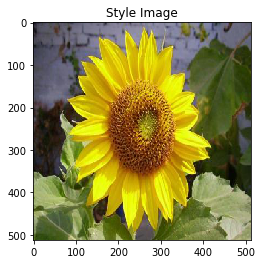

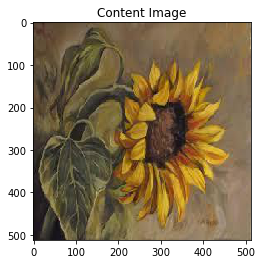

In [38]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.01) # pause a bit so that plots are updated

def edge(tensor, title=None, min=0, max=200):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    image = np.array(image) 
    image = image.copy() 
    edges = cv2.Canny(image,min,max)
    plt.imshow(edges, cmap='gray')
    
    edge_im = Image.fromarray(edges)
    edge_im = Variable(loader(edge_im))
    edge_im = edge_im.unsqueeze(0)
    return edge_im

plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

# plt.figure()
# style_edge = edge(style_img.data)

# plt.figure()
# content_edge = edge(content_img.data)


In [39]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [40]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [41]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [42]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [43]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

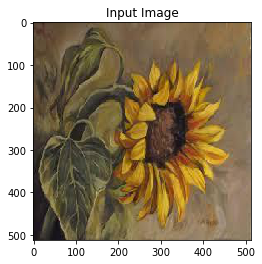

In [44]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# add the original input image to the figure:
plt.figure()
imshow(input_img.data, title='Input Image')

In [45]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [46]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                plt.figure()
                imshow(input_param.data, title='Output {}'.format(run))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.507607 Content Loss: 0.542362

run [100]:
Style Loss : 0.241880 Content Loss: 0.418671

run [150]:
Style Loss : 0.115377 Content Loss: 0.419837

run [200]:
Style Loss : 0.097826 Content Loss: 0.410123

run [250]:
Style Loss : 0.101571 Content Loss: 0.420456

run [300]:
Style Loss : 0.124116 Content Loss: 0.437728



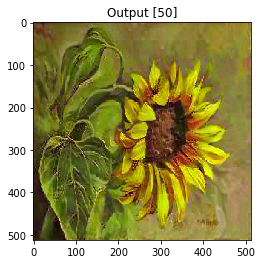

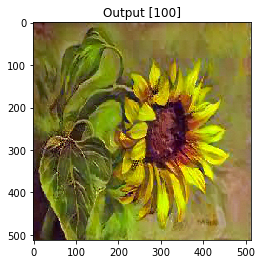

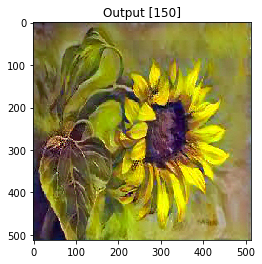

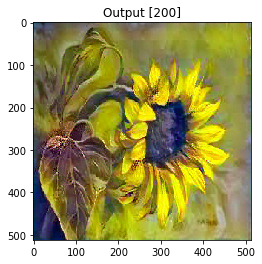

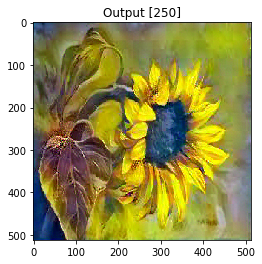

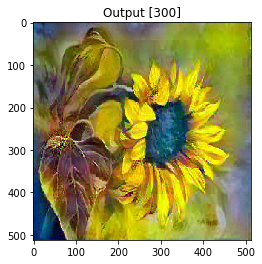

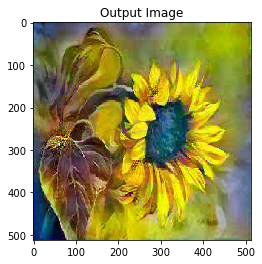

In [47]:
output = run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300, style_weight=1000, content_weight=1)
# output = run_style_transfer(cnn, style_img, content_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

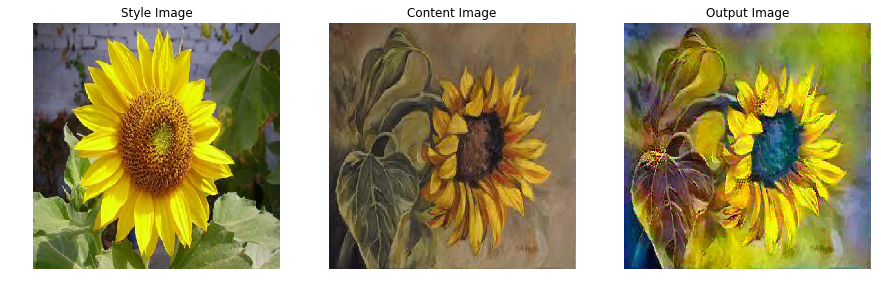

In [48]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.axis("off")
imshow(style_img.data, title='Style Image')

plt.subplot(132)
plt.axis("off")
imshow(content_img.data, title='Content Image')

plt.subplot(133)
plt.axis("off")
imshow(output, title='Output Image')

plt.savefig('sunflower.jpg')

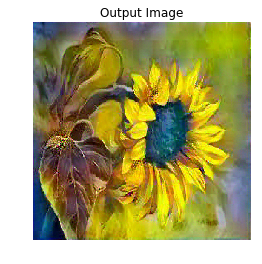

In [49]:
plt.figure()
plt.axis("off")
imshow(output, title='Output Image')
plt.savefig('output.jpg')